In [1]:
# append the parent folder of ark to sys.path
import sys
sys.path.append(r"E:\Users\Claris_Gu\PycharmProjects\python_project\Cell Segmentation\astir")

In [2]:
import anndata
from astir.data import from_csv_yaml, from_anndata_yaml # ignoring warnings since importing from local installation of astir
import yaml
import os.path as osp
import numpy as np
import pandas as pd
from scipy.stats.mstats import winsorize

e:\Users\Claris_Gu\miniconda3\envs\imc\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load ICI-mean-intensity data

In [3]:
sep = '\t'
usecols = [ 'CD45', 'CD4', 'CD68', 'CD20', 
            'CD8a', 'SOX10', 'CD40', 'CD3', 'S100', 'CD14', 
            'CD31']
ICI_dir = 'ICI'

In [4]:
# Read in yaml file for illustration purposes
with open(osp.join(ICI_dir, 'ICI_markers.yml'), 'r') as file:
  cell_types = yaml.load(file)

  print(cell_types['cell_types'])

{'Cytotoxic T cell': ['CD3', 'CD45', 'CD8a'], 'Helper T cell': ['CD3', 'CD45', 'CD4'], 'B cell': ['CD20'], 'Melenoma cell': ['SOX10', 'S100'], 'Vascular differentiation': ['CD31'], 'Macrophage': ['CD14', 'CD68']}


## Transform ICI_meanIntensity data

In [5]:
def arcsinh(data, cofactor=5):
    return np.arcsinh(data) / 5

In [86]:
# arcsinh normalization with a co-factor of 5 and winsorization to [0%, 99%]
# ICI_data = pd.read_csv(osp.join(ICI_dir, "ICI_meanIntensity.tsv"), usecols=usecols, sep='\t').values
# ICI_data = winsorize(arcsinh(ICI_data), limits=(0.0, 0.01), axis=0, inplace=True) # Series cannot be winsorized, has to use .values
# pd.DataFrame(ICI_data, columns=usecols).to_csv(osp.join(ICI_dir, "ICI_transformed.tsv"), sep='\t')

In [6]:
ast = from_csv_yaml(osp.join(ICI_dir, "ICI_transformed.tsv"), osp.join(ICI_dir, "ICI_markers.yml"), sep=sep)
ast

## Train the model

In [20]:
# Create batch size proportional to the number of cells
N = ast.get_type_dataset().get_exprs_df().shape[0]
batch_size = N // 128

# # Number of training epochs
# max_epochs = 1000

# # Set learning rate
# learning_rate = 1e-4

# # Set initial epochs
# initial_epochs = 3

# try different compbinations of paramenters and plot losses
max_epochs = np.arange(start=100, stop=1100, step=100)
learning_rates = np.arange(start=1e-4, stop=1e-3, step=0.0001)
# TODO: What does initial epochs do?
# TODO: What does NN do? 
initial_epochs = np.arange(start=3, stop=6)


Assign cell types

In [ ]:
min_loss = 0
for max_epoch in max_epochs:
    for lr in learning_rates:
        for initial_epoch in initial_epochs:
            ast.fit_type(max_epochs = max_epoch,
                        batch_size = batch_size,
                        learning_rate = lr,
                        n_init_epochs = initial_epoch)
            if min(ast.get_type_losses()) < min_loss:
                min_loss = min(ast.get_type_losses()).item()
                ast.save_models(osp.join(ICI_dir, "models/min_astir_model.hdf5"))
            

In [44]:
ast.load_model(osp.join(ICI_dir, "models/min_astir_model.hdf5"))

In [48]:
ast.get_type_run_info()

{'learning_rate': 0.0008,
 'n_init_epochs': 4,
 'batch_size': 924.0,
 'n_init': 5,
 'delta_loss': 0.001,
 'max_epochs': 100}

In [59]:
ast.fit_type(max_epochs = 1000,
            batch_size = 100,
            learning_rate = 1e-4,
            n_init_epochs = 5)

training restart (final):   2%|▏         | 19/1000 [ 9.16s/epochs, current loss: -1179505.3]


Plot type losses

Text(0.5, 0, 'Epoch')

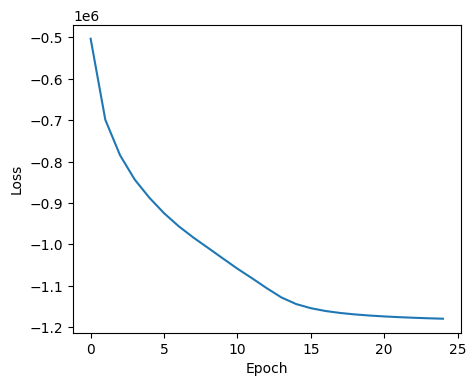

In [60]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,4))
plt.plot(np.arange(len(ast.get_type_losses())), ast.get_type_losses())
plt.ylabel("Loss")
plt.xlabel("Epoch")

Importantly, Astir automatically creates a design matrix based on additional covariates in the data such as batches. This is done using additional columns already present in the input data. In the example data of this vignette we have included a 'batch' column for the purposes of illustration.

We can get the cell type assignments in one of two ways:
1. Using `get_celltypes()`: this returns the most likely cell type or classifies a cell as unknown if no cell type has a probability above 0.7. (This threshold can be altered by the user with the threshold argument)
2. Using `get_celltype_probabilities()`: this returns the probabilty of each cell being assigned to any given cell type.

In [46]:
ast.get_celltypes().value_counts()

cell_type               
Melenoma cell               46200
Other                       36372
Macrophage                   9150
Helper T cell                6128
Cytotoxic T cell             6096
Unknown                      5837
B cell                       4926
Vascular differentiation     3655
dtype: int64

## Post-fit diagnostics

As a sanity check for the user, Astir also outputs a set of post-fit diagnostics. These ensure that all cell types express their marker proteins at significantly higher levels that other cells.

In [ ]:
ast.diagnostics_celltype()

In [ ]:
ast.get_celltype_probabilities()

## Analyzing our data

Now that we have assigned cell types to all cells, we can do some basic analysis.

Let us start with a t-SNE plot coloured by cell type. (This may take a while because it has to run t-SNE first).

In [47]:
import pandas as pd
ICI_meanIntensity = anndata.read_csv(osp.join(ICI_dir, 'ICI_transformed.tsv'), delimiter='\t')

In [12]:
import scanpy
scanpy.tl.tsne(ICI_meanIntensity, perplexity=30) 

ICI_meanIntensity.obs["cell_type"] = ast.get_celltypes(assignment_type='max').values

In [14]:
from itertools import chain
m_list = [x for x in cell_types['cell_types'].values()]
markers = list(chain.from_iterable(m_list))

markers = list(set(markers))

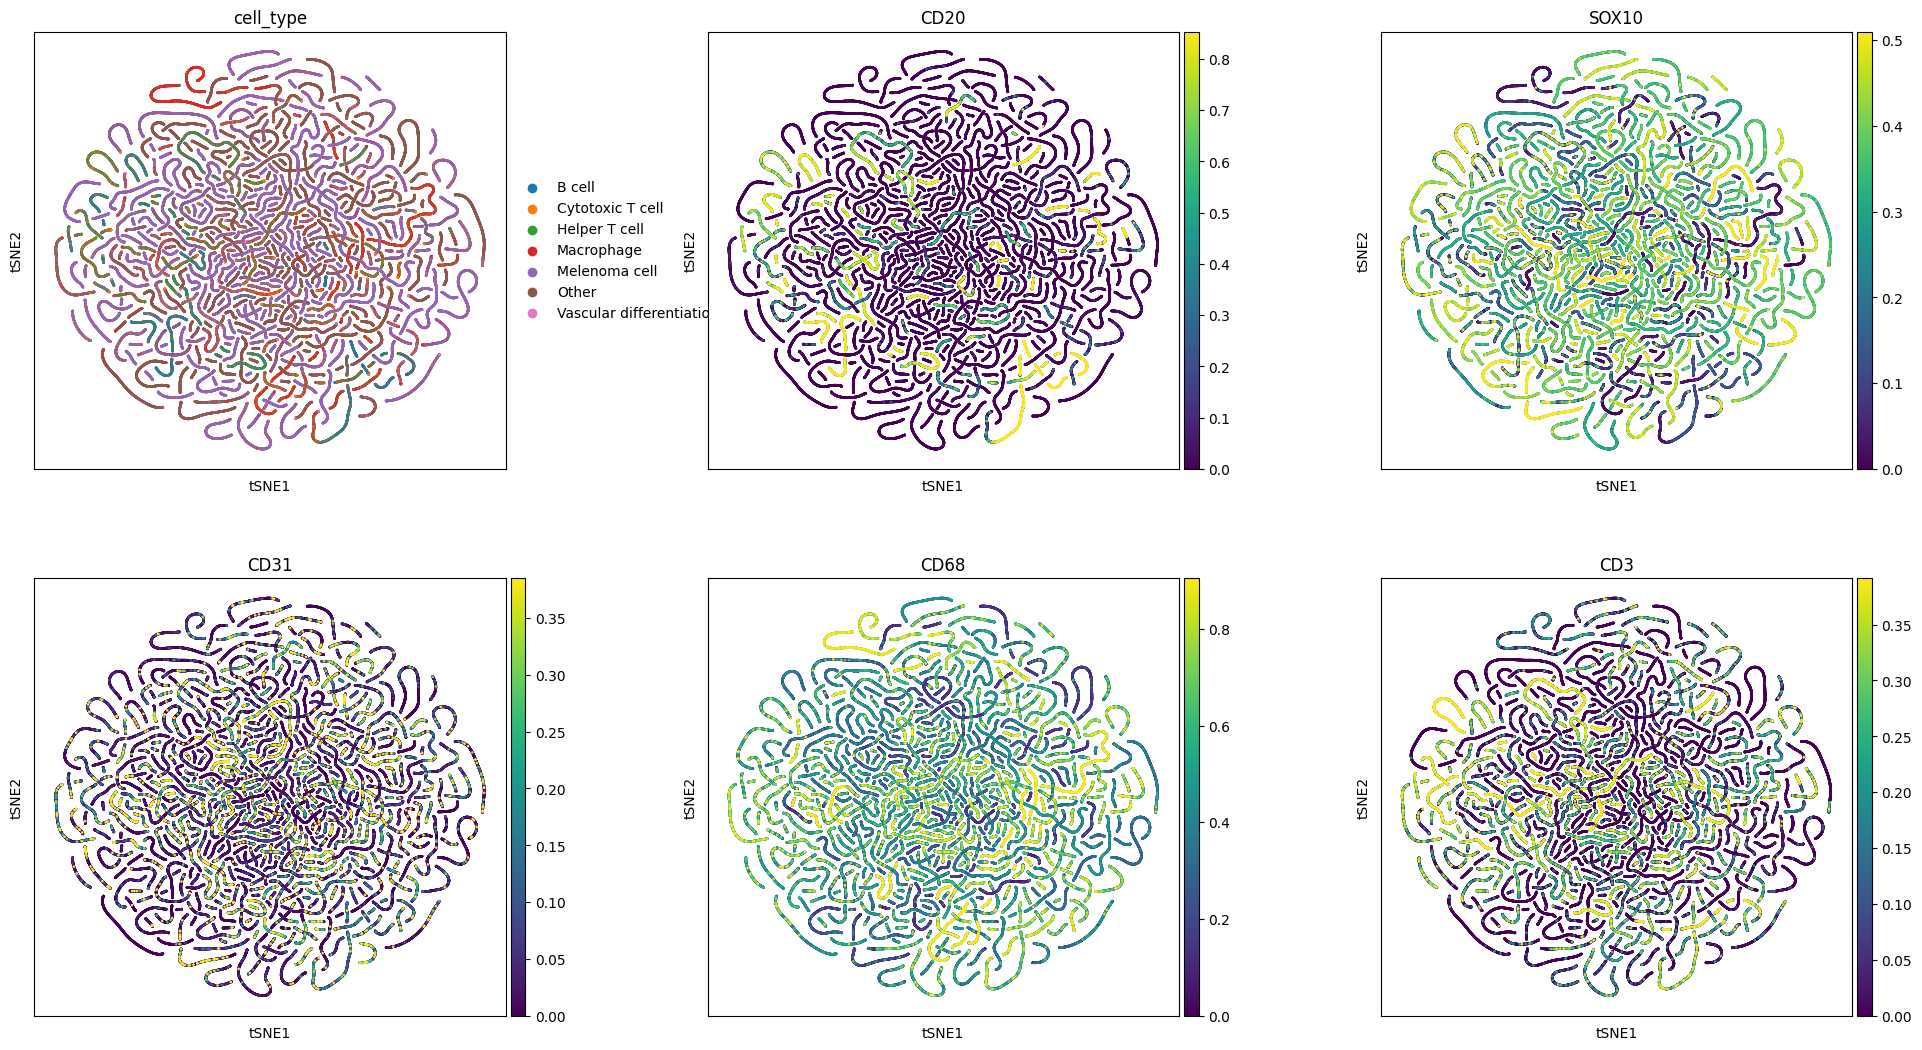

In [15]:
# color by markers
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (6, 6)}):
  scanpy.pl.tsne(ICI_meanIntensity, color = ['cell_type', 'CD20', 'SOX10', 'CD31', 'CD68', 'CD3'], size = 14, ncols = 3, wspace = 0.3)

In [ ]:
scanpy.pp.neighbors(ICI_meanIntensity)
scanpy.tl.umap(ICI_meanIntensity)

In [ ]:
# color by markers
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (6, 6)}):
  scanpy.pl.umap(ICI_meanIntensity, color = ['cell_type', 'CD20', 'SOX10', 'CD31', 'CD68', 'CD3'], size = 14, ncols = 3, wspace = 0.3)

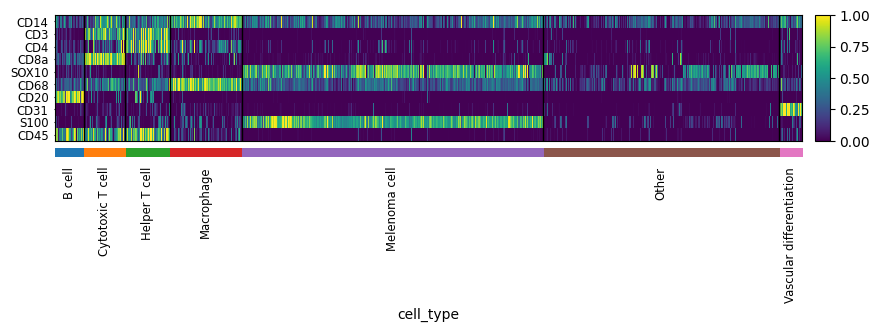

In [135]:
scanpy.pl.heatmap(ICI_meanIntensity, markers, groupby='cell_type', swap_axes=True, standard_scale='var')

## Use pre-trained astir model to predict cell types

In [3]:
import astir
ast = astir.Astir()
ast.load_model("jackson_astir_model.hdf5")

In [4]:
import pandas as pd
# import torch
# ICI_meanIntensity = pd.read_csv(osp.join(ICI_dir, 'ICI_transformed.tsv'), sep='\t')
# ICI_meanIntensity = torch.tensor(ICI_meanIntensity.values)
ad = anndata.read_h5ad("basel_22k_subset.h5ad")
df = ad.to_df()
predicted_celltypes = ast.predict_celltypes(df)

e:\Users\Claris_Gu\PycharmProjects\python_project\Cell Segmentation\astir\astir\astir.py:546: UserWarning: The state model has not been trained for enough epochs yet
  warnings.warn(msg)


TypeError: linear(): argument 'input' (position 1) must be Tensor, not DataFrame

In [6]:
import pandas as pd
ICI_meanIntensity = anndata.read_csv(osp.join(ICI_dir, 'ICI_transformed.tsv'), delimiter='\t')

#plot tSNE 
import scanpy
scanpy.tl.tsne(ICI_meanIntensity, perplexity=50)
ICI_meanIntensity.obs["cell_type"] = ast.predict_celltypes(assignment_type='max').values

# color by markers
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (6, 6)}):
  scanpy.pl.tsne(ICI_meanIntensity, color = ['cell_type', 'CD20', 'SOX10', 'CD31', 'CD68', 'CD3'], size = 14, ncols = 3, wspace = 0.3)

KeyboardInterrupt: 